In [53]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin

We load in the data from sklearn, one-hot encode the labels and split the data into train and test datasets. 

In [52]:
np.random.seed(2024)

# Loading in the data
cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

# one-hot encoding the data
y = tf.keras.utils.to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Tensorflow model

We create a model similar to the one implemented by hand, using tensorflow:

In [57]:
def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(30,)))                       # input layer
    model.add(tf.keras.layers.Dense(50, activation='sigmoid'))          # hidden layer
    model.add(tf.keras.layers.Dense(2, activation='softmax'))           # output layer

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.01,
                                momentum=0.0,  
                                name='SGD'), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

We create a class for wrapping the tensorflow-model in sklearn, so that we can easily use sklearn-related functionalities. This is done using BaseEstimator and ClassifierMixin.

In [54]:
class TFClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn=None, epochs=10, batch_size=32, verbose=0):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model_ = None

    def fit(self, X, y):
        self.model_ = self.build_fn()
        self.model_.fit(X, y, epochs=self.epochs, 
                        batch_size=self.batch_size, verbose=self.verbose)
        return self
    
    def predict(self, X):
        return np.argmax(self.model_.predict(X), axis=-1)
    
    def score(self, X, y):
        _, accuracy = self.model_.evaluate(X, y, verbose=self.verbose)
        return accuracy

We use pipeline to first scale the data and then train the tensorflow-model. Then we fit the data and test the accuracy on the test-dataset.

In [58]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', TFClassifier(build_fn=create_model, epochs=50, batch_size=10))
])

# getting data for confusion matrix
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evauluate the model
accuracy = pipeline.score(X_test, y_test)
print(f'test accuracy: {accuracy:.4f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
test accuracy: 0.9649


We plot the confusion matrix for the data

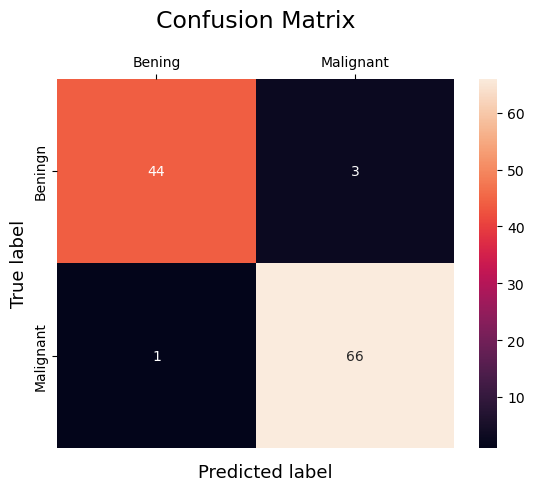

In [59]:
# Calculating the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), y_pred)

# Plotting the confusion matrix
ax = sns.heatmap(cm, 
            annot=True,
            xticklabels=['Bening','Malignant'],
            yticklabels=['Beningn','Malignant'])
plt.ylabel('True label', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20, loc='center')
ax.set(xlabel="", ylabel="True label")
ax.xaxis.tick_top()

plt.gca().figure.text(0.45, 0.05, 'Predicted label', ha='center', fontsize=13)
plt.show()
